# <p style="padding:10px;background-color:#324459;margin:0;color:#eab578;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Census Income Analysis and Modeling</p>

<p style="text-align:center; ">
<img src="https://pix4free.org/assets/library/2021-04-28/originals/income.jpg" style='width: 500px; height: 350px;'>
</p>


**In this kernel I will create a machine learning model on the Census Income dataset. The objective of this project is to build a model to predict whether personal income would be over 50 or not based on pattern extracted from analysing features.**




# Importing data and libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#machine learning libraries:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

#evaluation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.metrics import r2_score,f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data= pd.read_csv(r"/kaggle/input/census-income-dataset/adult.csv")
test_data= pd.read_csv(r"/kaggle/input/census-income-dataset/adult.test.csv")

train_data.head()

,Age,Workclass,Final Weight,Education,EducationNum,Marital Status,Occupation,Relationship,Race,Gender,Capital Gain,capital loss,Hours per Week,Native Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
test_data.head()

,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0.1,40,United-States,<=50K.
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
3,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.


It seem test data has unnamed columns so let's handle that.




In [4]:
columns=train_data.columns
test_data.columns=columns

In [5]:
df = pd.concat([train_data, test_data], axis= 0)

In [6]:
df.head(5)

,Age,Workclass,Final Weight,Education,EducationNum,Marital Status,Occupation,Relationship,Race,Gender,Capital Gain,capital loss,Hours per Week,Native Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# data cleaning

In [7]:
#strip string columns

for col in columns:
    if df[col].dtype in ['O']:
        df[col]=df[col].str.strip()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48841 entries, 0 to 16279
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             48841 non-null  int64 
 1   Workclass       48841 non-null  object
 2   Final Weight    48841 non-null  int64 
 3   Education       48841 non-null  object
 4   EducationNum    48841 non-null  int64 
 5   Marital Status  48841 non-null  object
 6   Occupation      48841 non-null  object
 7   Relationship    48841 non-null  object
 8   Race            48841 non-null  object
 9   Gender          48841 non-null  object
 10  Capital Gain    48841 non-null  int64 
 11  capital loss    48841 non-null  int64 
 12  Hours per Week  48841 non-null  int64 
 13  Native Country  48841 non-null  object
 14  Income          48841 non-null  object
dtypes: int64(6), object(9)
memory usage: 6.0+ MB


### Handle missing data

In [9]:
df['Workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

**`?` It expresses as missing data so let's change it.**

In [10]:
df.replace("?", np.NaN, inplace=True)

In [11]:
data_na = df.isna().sum()
data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)

Occupation        2809
Workclass         2799
Native Country     857
dtype: int64

In [12]:
len(df[df['Workclass'].isna() & df['Occupation'].isna()])

2799

In [13]:
df[df['Occupation'].isna() & ~df['Workclass'].isna()]

,Age,Workclass,Final Weight,Education,EducationNum,Marital Status,Occupation,Relationship,Race,Gender,Capital Gain,capital loss,Hours per Week,Native Country,Income
5361,18,Never-worked,206359,10th,6,Never-married,NaN,Own-child,White,Male,0,0,40,United-States,<=50K
10845,23,Never-worked,188535,7th-8th,4,Divorced,NaN,Not-in-family,White,Male,0,0,35,United-States,<=50K
14772,17,Never-worked,237272,10th,6,Never-married,NaN,Own-child,White,Male,0,0,30,United-States,<=50K
20337,18,Never-worked,157131,11th,7,Never-married,NaN,Own-child,White,Female,0,0,10,United-States,<=50K
23232,20,Never-worked,462294,Some-college,10,Never-married,NaN,Own-child,Black,Male,0,0,40,United-States,<=50K
32304,30,Never-worked,176673,HS-grad,9,Married-civ-spouse,NaN,Wife,Black,Female,0,0,40,United-States,<=50K
32314,18,Never-worked,153663,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,4,United-States,<=50K
8784,17,Never-worked,131593,11th,7,Never-married,NaN,Own-child,Black,Female,0,0,20,United-States,<=50K.
11606,20,Never-worked,273905,HS-grad,9,Married-spouse-absent,NaN,Other-relative,White,Male,0,0,35,United-States,<=50K.
13897,18,Never-worked,162908,11th,7,Never-married,NaN,Own-child,White,Male,0,0,35,United-States,<=50K.


In [14]:
df['Workclass'].value_counts()

Workclass
Private             33905
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

**There are 2799 rows in the `Occupation` column and the `Workclass` that are missing. But `Occupation` column has 10 missing data more becouse the person doesn't work.**

**So we replace these data with `No-occupation`**

In [15]:
df[df['Workclass']=='Never-worked']= df[df['Workclass']=='Never-worked'].fillna('No-occupation')

In [16]:
df['Native Country'].value_counts()[:5]

Native Country
United-States    43831
Mexico             951
Philippines        295
Germany            206
Puerto-Rico        184
Name: count, dtype: int64

In [17]:
df['Native Country'].fillna('United-States', inplace=True)

In [18]:
data_na = df.isna().sum()
data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)

Workclass     2799
Occupation    2799
dtype: int64

In [19]:
df.dropna(inplace=True)

### Capital Gain and loss columns

In [20]:
len1, len2 = len(df[df['Capital Gain']== 0])/len(df), len(df[df['capital loss']== 0])/len(df)

print(round(len1,2),'%', round(len2,2),'%')

0.92 % 0.95 %


**Most of 90% of Capital Gain and loss columns equal 0.** 

**These columns may be difficult to model. Machine learning models often have difficulty learning from these columns and make the model less accurate.**



In [21]:
df.drop(columns=['Capital Gain', 'capital loss'], inplace=True)

In [22]:
df.head()

,Age,Workclass,Final Weight,Education,EducationNum,Marital Status,Occupation,Relationship,Race,Gender,Hours per Week,Native Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K


In [23]:
df['Income'].unique()

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

let's correct that.

In [24]:
df.replace({'Income':{">50K.":">50K" , "<=50K.":"<=50K"}},inplace=True)

In [25]:
(df['Native Country'].value_counts()/len(df))[:5]

Native Country
United-States    0.914643
Mexico           0.019613
Philippines      0.006147
Germany          0.004192
Puerto-Rico      0.003801
Name: count, dtype: float64

**Most of 90% of the `Native Country` is  United-States. That make our model less accurate and misleading.**

**let's drop this column**

In [26]:
df.drop(columns='Native Country', inplace=True)

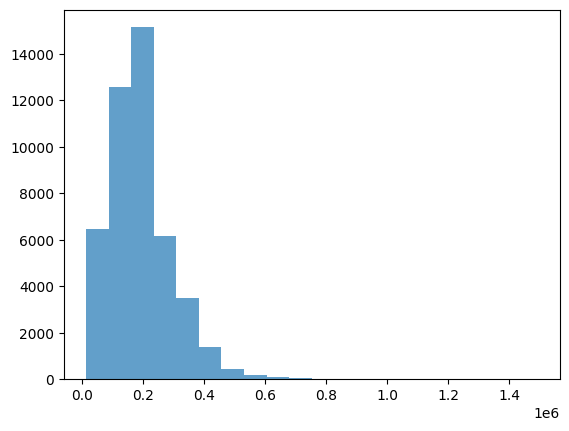

In [27]:
plt.hist(df['Final Weight'], bins=20, alpha=0.7);

In [28]:
mask = df['Final Weight'] > 0.6*1000000

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'Final Weight'] = np.ceil(df['Final Weight'].mean())

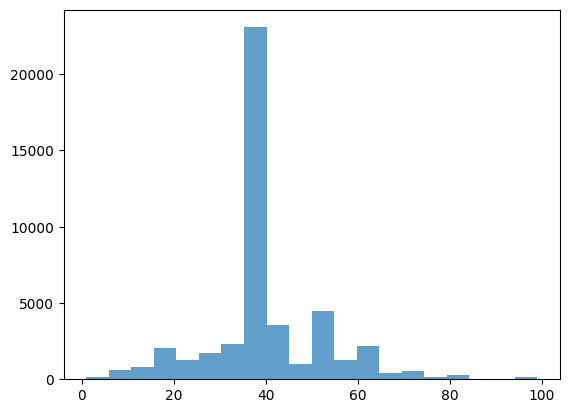

In [29]:
plt.hist(df['Hours per Week'], bins=20, alpha=0.7);

# Visualization

<img src="https://image.freepik.com/free-vector/site-stats-concept-illustration_114360-1434.jpg" width=300>

In [30]:
def add_value_labels(ax, spacing=5):

    # For each bar: Place a label    
    for rect in ax.patches:
        
        # Get X and Y placement of label from rect.
        x = rect.get_x() + rect.get_width() / 2
        y = rect.get_height()-4

        # Determine vertical alignment for positive and negative values
        va = 'bottom' if y >= 0 else 'top'

        # Format the label to one decimal place
        label = int(y)    #"{}".format(y)

        # Determine the vertical shift of the label
        # based on the sign of the y value and the spacing parameter
        y_shift = spacing * (1 if y >= 0 else -1)

        # Create the annotation
        ax.annotate(label, (x, y), xytext=(0, y_shift),
                    textcoords="offset points", ha='center', va=va)
        
pal = ['#93bac2','#adc293','#c29793', '#E28F6B', '#76A15A', '#838477' ]

def r_color(num=1, seed=None):

    if seed == None:
        seed = np.random.randint(0, 420, size=1)
        np.random.seed(seed)

    colors = np.random.choice(pal, num, replace=False)

    # Return the colors
    return list(colors)

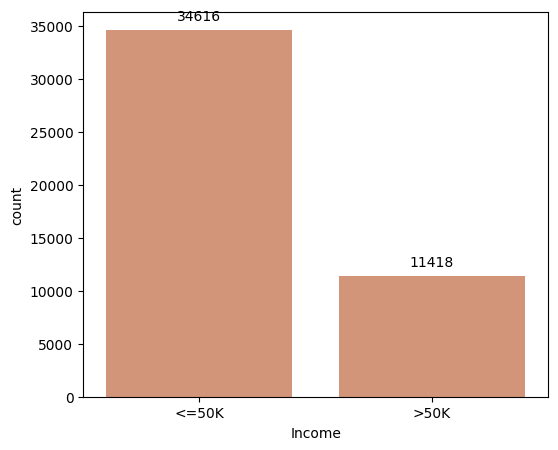

In [31]:
Workclass_data=df['Income'].value_counts()
order= list(Workclass_data.index)

plt.figure(figsize=(6,5))
plot= sns.countplot(data=df, x='Income', order=order, palette = r_color(num=1))
add_value_labels(plot)

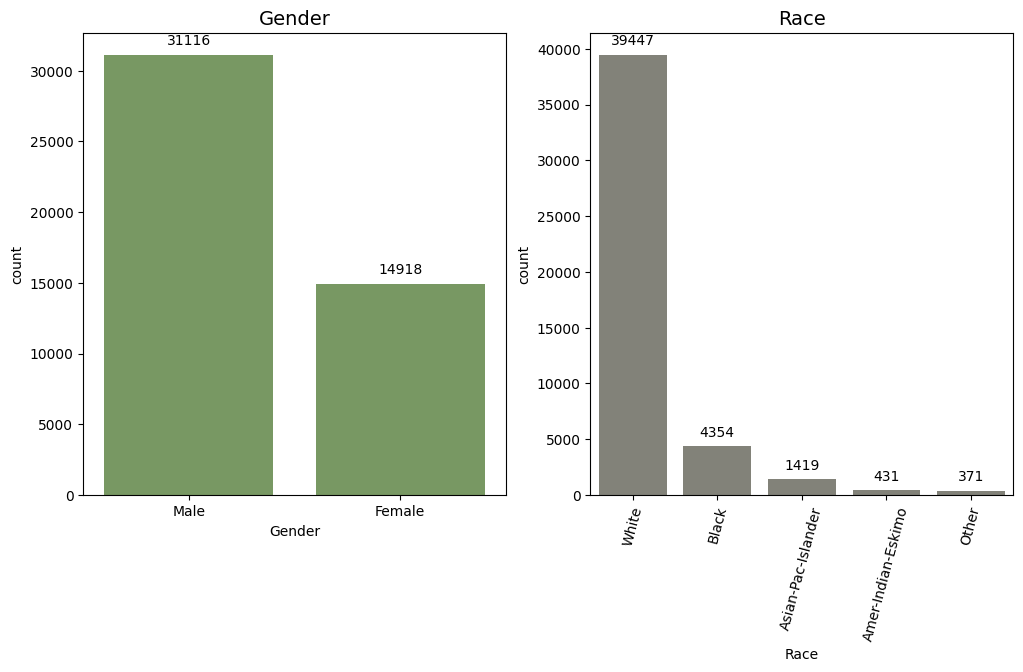

In [32]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Gender', size=14)
plot=sns.countplot(data=df, x='Gender', palette = r_color(num=1,seed=0))
add_value_labels(plot)

plt.subplot(1,2,2)
plt.title('Race', size=14)
plot=sns.countplot(data=df, x='Race', palette = r_color(num=1, seed=2))
plt.xticks(rotation=75)
add_value_labels(plot)

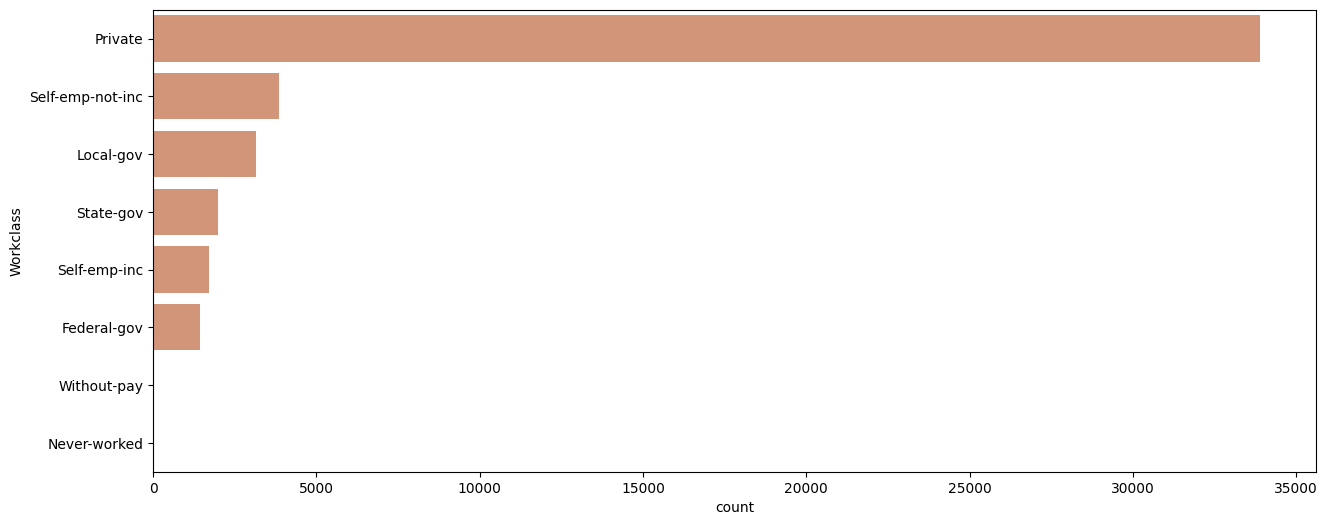

In [33]:
Workclass_data=df['Workclass'].value_counts()
order= list(Workclass_data.index)

plt.figure(figsize=(15,6))
plot= sns.countplot(data=df, y='Workclass', orient="h", order=order,  palette = r_color(num=1))


* **The majority of people in the census dataset have jobs in the private sector. This suggests that the private sector is the largest employer in the economy.**
* **Self-employment is also relatively common, with over 6,000 people in the dataset classified as Self-emp-not-inc or Self-emp-inc. This suggests that there is a significant number of people who are starting their own businesses or working for themselves.**
* **Government jobs are less common, but still represent a significant portion of the workforce.**

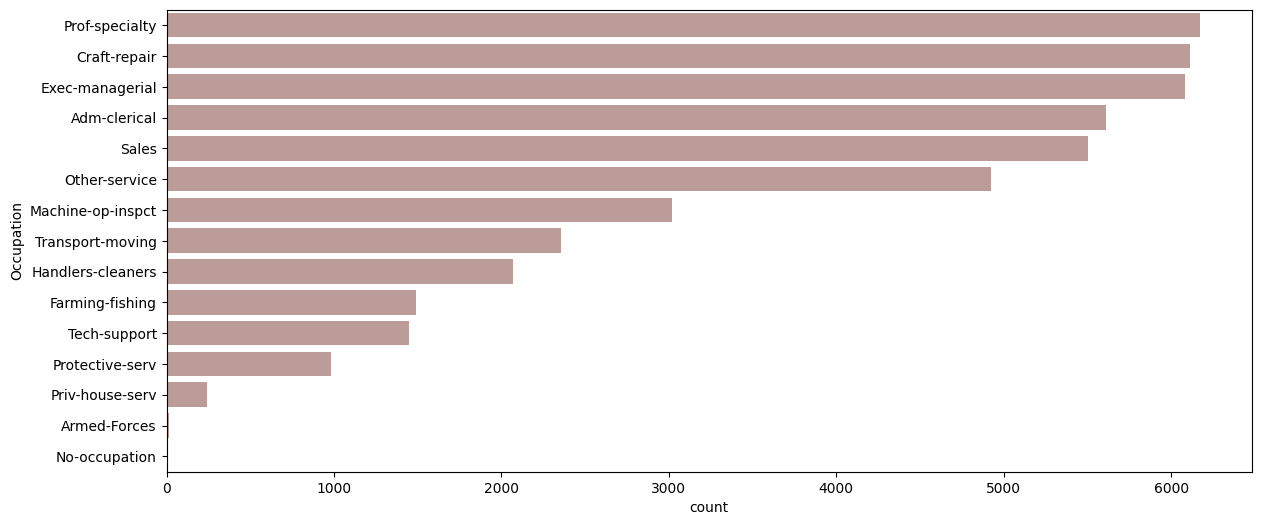

In [34]:
Occupation_data=df['Occupation'].value_counts()
order= list(Occupation_data.index)

plt.figure(figsize=(14,6))
plot= sns.countplot(data=df, y='Occupation', orient="h", order=order, palette = r_color(num=1,seed=0))

In [35]:
Relationship_data=df['Relationship'].value_counts()

order= list(Relationship_data.index)
values = list(Relationship_data.values)

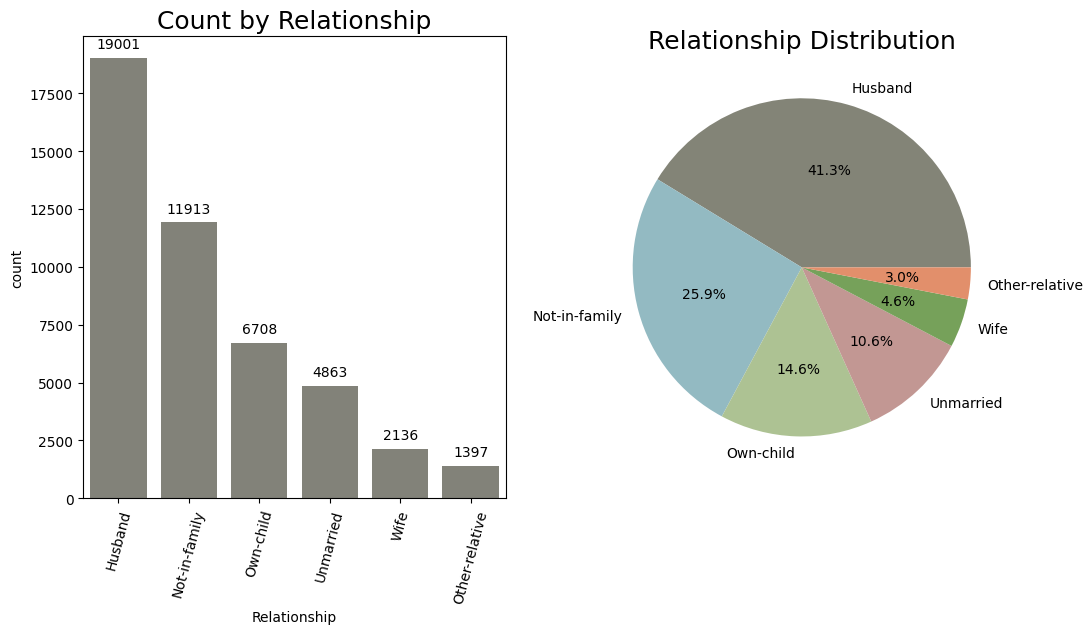

In [36]:
plt.figure(figsize=(12,6))

# Plot the count bar plot
plt.subplot(1,2,1)
plot1= sns.countplot(data=df, x='Relationship', order=order, palette = r_color(num=1,seed=0))
plt.title('Count by Relationship', fontsize=18)
plt.xticks(rotation=75)
add_value_labels(plot1);

plt.subplot(1,2,2)
plt.pie(values, labels=order, autopct='%1.1f%%', colors= r_color(num=6,seed=0))
plt.title('Relationship Distribution', fontsize=18);

* **The majority of people are married or in a relationship.**
* **There is a significant number of unmarried people and not-in-family.**
* **There is a small number of people who are other relatives.**

In [37]:
Education_data=df['Education'].value_counts()
order1= list(Education_data.index)

EducationNum_data=df['EducationNum'].value_counts()
order2= list(EducationNum_data.index)

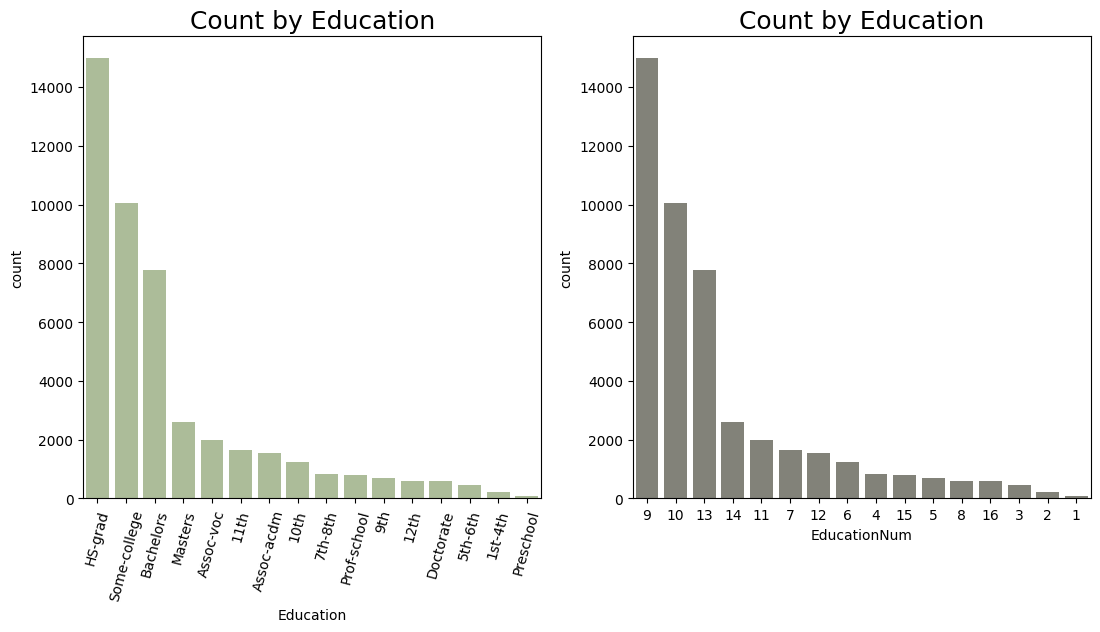

In [38]:
plt.figure(figsize=(13,6))

# Plot the count bar plot
plt.subplot(1,2,1)
plot1= sns.countplot(data=df, x='Education', order=order1, palette = r_color(num=1,seed=0))
plt.title('Count by Education', fontsize=18)
plt.xticks(rotation=75);

plt.subplot(1,2,2)
plot2= sns.countplot(data=df, x='EducationNum', order=order2, palette = r_color(num=1,seed=42))
plt.title('Count by Education', fontsize=18);

**You can notice that the `Education` column related with `EducationNum` column 
Where:**
* **HS-grad = 9 years of education completed.**
* **Some-college = 10**
* **Bachelors = 13**
* **Masters = 14**
* **Assoc-voc = 11   And So On..**

We will drop `Education` column.

In [39]:
df.drop(columns='Education', inplace=True)

In [40]:
df.head()

,Age,Workclass,Final Weight,EducationNum,Marital Status,Occupation,Relationship,Race,Gender,Hours per Week,Income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,<=50K
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,<=50K
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,<=50K


# Data encoding

In [41]:
ohe_cols = [col for col in df.columns if 42 >= df[col].nunique() > 2]
ohe_cols

['Workclass',
 'EducationNum',
 'Marital Status',
 'Occupation',
 'Relationship',
 'Race']

In [42]:
# label encoder

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

for col in ['Income', 'Gender']:
    df = label_encoder(df, col)

In [43]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    encoded_data = dataframe.copy()  # Make a copy of the original DataFrame
    
    for col in categorical_cols:
        dumm = pd.get_dummies(dataframe[col], prefix=col, dtype=int, drop_first=drop_first)
        del encoded_data[col]
        encoded_data = pd.concat([encoded_data, dumm], axis=1)
    
    return encoded_data

df = one_hot_encoder(df, ['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race'])

In [44]:
df.shape

(46042, 42)

# Building models

### Spliting data

In [45]:
X = df.drop("Income", axis=1)
y = df["Income"]

X_train, X_test, y_train, y_test = train_test_split(
    X , y ,
    test_size=0.2,
    random_state=42
)

In [46]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (36833, 41)
y_train shape: (36833,)
X_test shape: (9209, 41)
y_test shape: (9209,)


### Define models

In [47]:
Models = [
        
        ("SVM",      SVC()),     #Support Vector Machines
               
        ("kNN",      KNeighborsClassifier(n_neighbors = 3)),    #KNeighborsClassifier

        ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),   #Logistic Regression model

        ("DT_model", DecisionTreeClassifier(random_state=42)),    #Decision tree model

        ("RF_model", RandomForestClassifier(random_state=42, n_jobs=-1)),   #Random Forest model

        ("GradientBoosting",GradientBoostingClassifier(max_depth=2,     #GradientBoosting model
                                                      n_estimators=100))
        ]

In [ ]:
accuracies = {}
models = {}
model = Models
for name,model in Models:
    model.fit(X_train, y_train)
    models[name] = model
    acc = model.score(X_train, y_train)*100
    accuracies[name] = acc
    print("{} Accuracy Score : {:.3f}%".format(name,acc))

In [ ]:
models_res = pd.DataFrame(data=accuracies.items())
models_res.columns = ['Model','Test score']
models_res.sort_values('Test score',ascending=False)

In [ ]:
# Decision Tree
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train, y_train)

acc_train = round(DT_model.score(X_train, y_train) * 100, 2)
print(acc_train, "%")

acc_test = round(DT_model.score(X_test, y_test) * 100, 2)
print(acc_test, "%")

**it Sounds like overfitted.**

**Let's set our paramerters to reduce the effect of overfitting.**

In [ ]:
DT_model = DecisionTreeClassifier(max_depth=40, 
                                  max_features='auto',
                                  min_samples_leaf=40,
                                  min_samples_split=5,
                                  random_state=42)

DT_model.fit(X_train, y_train)

acc_train = round(DT_model.score(X_train, y_train) * 100, 2)
print(acc_train, "%")

acc_test = round(DT_model.score(X_test, y_test) * 100, 2)
print(acc_test, "%")

**We're almost done with the problem of overfitting.** 

## Evaluate DT_model

In [ ]:
Predictions = DT_model.predict(X_test)

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(y_test, Predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="gray_r", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, Predictions, average='weighted')
recall = recall_score(y_test, Predictions, average='weighted')
f1 = f1_score(y_test, Predictions, average='weighted')

# Print evaluation metrics
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

In [ ]:
#probabilities of our predictions
y_scores = DT_model.predict_proba(X_test) 

Roc_Auc_Score = roc_auc_score(y_test, y_scores[:,1])
print("ROC-AUC-Score:", Roc_Auc_Score)

In [ ]:
FPR, TPR, thresholds = roc_curve(y_test, y_scores[:,1])

plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1], 'g')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Auc - Roc curve',fontsize=15);

**ROC AUC Score: is the corresponding score to the ROC AUC Curve. It simply measure the area under the curve, which is called AUC.**

**the score is good enough**

***

<br>

<div style="text-align: center;">
   <span style="font-size: 4.5em; font-weight: bold; font-family: Arial;">THANK YOU!</span>
</div>/

<br>
<br>

<br>

<div style="text-align: center;">
   <span style="font-size: 1.4em; font-weight: bold; font-family: Arial; max-width:1200px; display: inline-block;">
       If you find this notebook useful, I'd greatly appreciate your upvote!
   </span>
</div>